In [1]:
pip install annoy -U

Requirement already up-to-date: annoy in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (1.17.0)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

FEATURE EXTRACTION

STEP 1: extract features from pretrained models like VGG-16, VGG-19, ResNet-50, InceptionV3 and MobileNet
        and benchmark them using the Caltech101 dataset.

In [5]:
cd Downloads/101_ObjectCategories

/Users/adithisu/Downloads/101_ObjectCategories


In [15]:
rm -rf BACKGROUND_Google

In [16]:
ls

Faces/           crab/            inline_skate/    saxophone/
Faces_easy/      crayfish/        joshua_tree/     schooner/
Leopards/        crocodile/       kangaroo/        scissors/
Motorbikes/      crocodile_head/  ketch/           scorpion/
accordion/       cup/             lamp/            sea_horse/
airplanes/       dalmatian/       laptop/          snoopy/
anchor/          dollar_bill/     llama/           soccer_ball/
ant/             dolphin/         lobster/         stapler/
barrel/          dragonfly/       lotus/           starfish/
bass/            electric_guitar/ mandolin/        stegosaurus/
beaver/          elephant/        mayfly/          stop_sign/
binocular/       emu/             menorah/         strawberry/
bonsai/          euphonium/       metronome/       sunflower/
brain/           ewer/            minaret/         tick/
brontosaurus/    ferry/           nautilus/        trilobite/
buddha/          flamingo/        octopus/         umbrella/
butterfly/       f

In [6]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

Load the ResNet-50 model without the top classification layers(only bottleneck features remain)

In [7]:
model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None
)

In [8]:
def extract_features(img_path, model):
    input_shape =(224,224,3)
    img = image.load_img(img_path, target_size=(input_shape[0],input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array,axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [32]:
features = extract_features('Faces/image_0001.jpg',model)
print(len(features))

100352


In [35]:
# ResNet model generated 100352 features from the provided image. 
# Each feature is a floating point value between 0 and 1

In [9]:
extensions = ['.jpg','.JPG','.jpeg','.JPEG','.png','.PNG']
# function to recursively look for all the image files within the directory
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root,filename))
                counter+=1
    return file_list

In [10]:
root_dir = '/Users/adithisu/Downloads/101_ObjectCategories'
filenames = sorted(get_file_list(root_dir))

In [11]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

<ipython-input-11-21d73bc1ed80>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/8677 [00:00<?, ?it/s]

SIMILARITY SEARCH

Given a photograph, our aim is to find another photo in our dataset which is similar to the current one using
scikit-learn

In [13]:
pip install sklearn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [44]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',metric='euclidean').fit(feature_list)
# lazylearning
# indices and distances of the nearest 5 neighbors of the first query feature( which represents first image)

In [16]:
pip install matplotlib

     |████████████████████████████████| 8.5 MB 10.1 MB/s eta 0:00:01|███████████████▍                | 4.1 MB 2.3 MB/s eta 0:00:02
     |████████████████████████████████| 61 kB 61 kB/s  eta 0:00:011
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

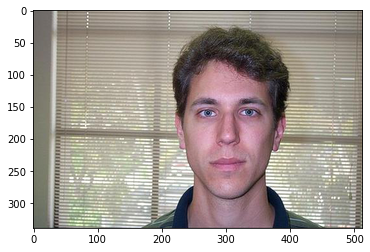

In [49]:
random_index = 45
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

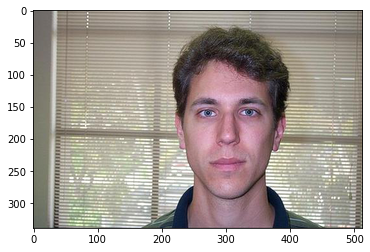

In [52]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]), interpolation='lanczos')
# Actual image behind the feature

In [53]:
# Duplicate? Nearest index will be the image itself because that is what is being queries:
for i in range(5):
    print(distances[0][i])

1.05892646e-07
0.85578096
0.85880274
0.8598016
0.8902609


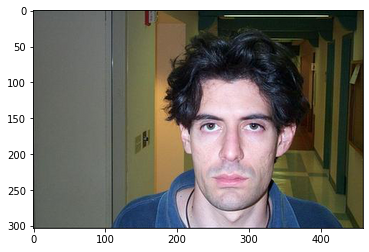

In [54]:
# examine the first nearest neighbor
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')

In [56]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

<ipython-input-56-a321f6ddd2f4>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
<ipython-input-56-a321f6ddd2f4>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
<ipython-input-56-a321f6ddd2f4>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
<ipython-input-56-a321f6ddd2f4>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(ima

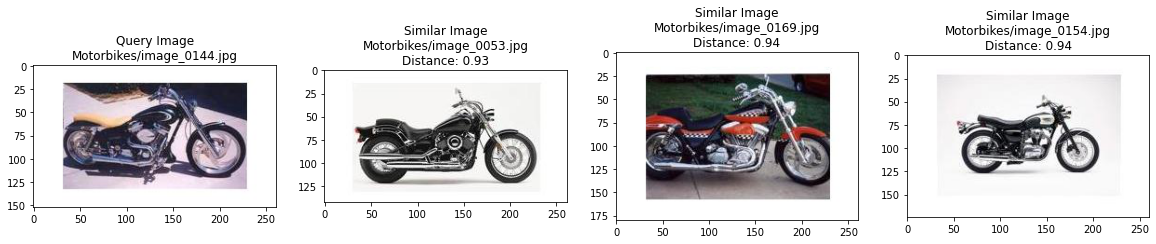

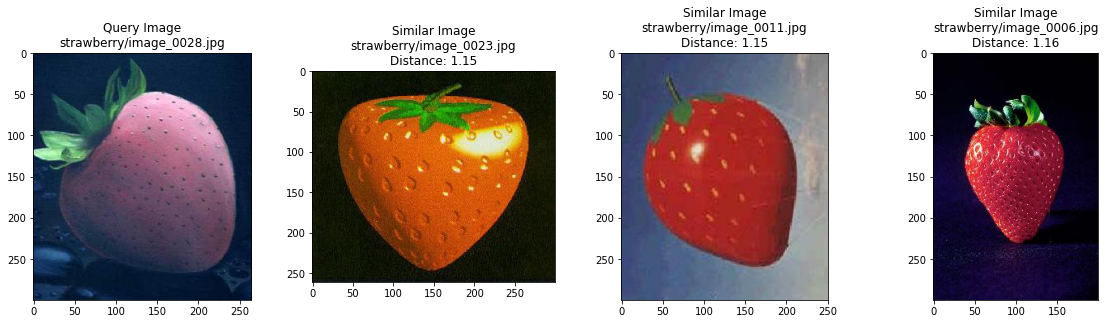

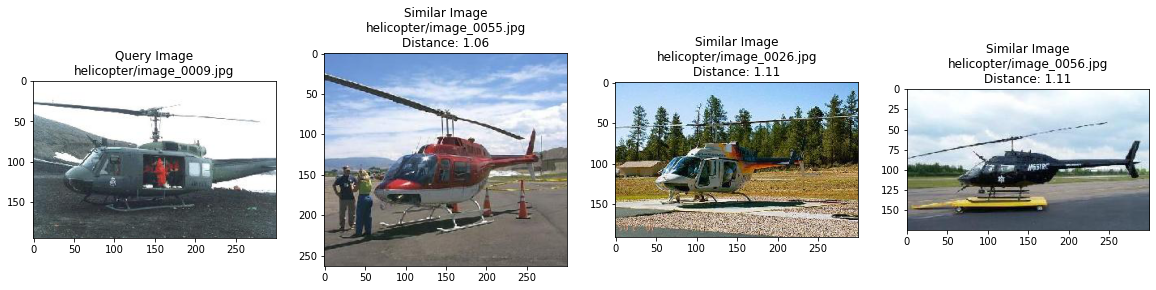

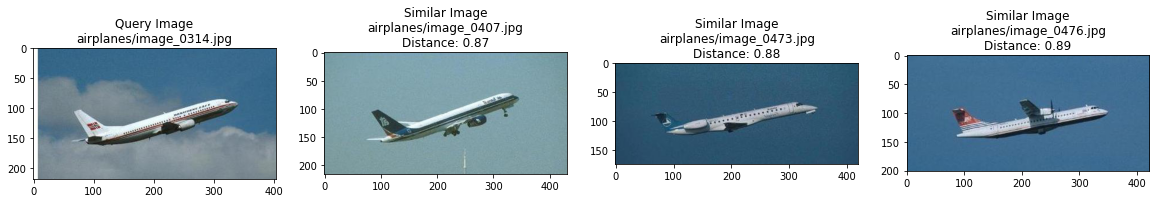

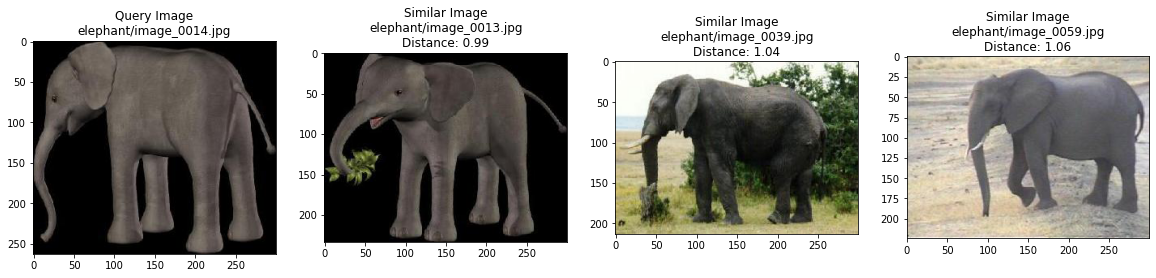

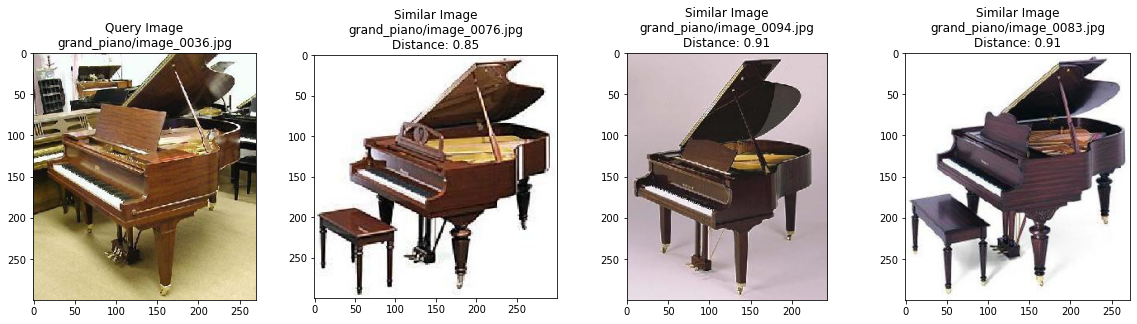

In [57]:
num_images = len(filenames)
for i in range(6):
    random_image_index = random.randint(0,num_images)
    distances,indices = neighbors.kneighbors([feature_list[random_image_index]])
    #exclude the first closest image
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,4)]
    plot_images(similar_image_paths, distances[0])

VISUALIZING IMAGE CLUSTERS WITH t-SNE

t-SNE or t-distributes stochastic neighbor embedding algorithm reduces high dimensional feature vector to 2D,
providing a bird's eye view of the dataset . t-SNE is difficult to scale to large datasets,
so its preferable to reduce the dimensionality using Principal Component Analysis (PCA) and then call t-SNE

In [60]:
from sklearn.decomposition import PCA

In [61]:
# PCA over the features
num_feature_dimensions = 100 
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

KeyboardInterrupt: 

In [ ]:
# analyze about the first half of dataset
selected_features = feature_list_compressed[:4000]
selected_class_ids = class_ids[:4000]
selected_filenames = filenames[:4000]
tsne_results = TSNE(n_components = 2, verbose=1, metric = 'euclidean').fit_transform(selected_features)

In [ ]:
# plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1],c=selected_class_ids, cmap = colormap)
plt.colorbar(scatter_plot)
plt.show()

IMPROVING THE SPEED OF SIMILARITY SEARCH

Two possible strategies:
1. Reduce the feature-length
2. Use better algorithm to search among the features